In [14]:
from abc import ABC, abstractmethod
from typing import Tuple, List

import einops as ein
import numpy as np
import torch as t
import torch.nn.functional as F
from jaxtyping import Bool, Float, Int, jaxtyped
from PIL import Image
from typeguard import typechecked as typechecker

In [15]:
@jaxtyped(typechecker=typechecker)
def tensor_to_image(tensor: Float[t.Tensor, "h w c"] | Int[t.Tensor, "h w c"]) -> Image.Image:
    array = tensor.cpu().numpy().astype(np.uint8)
    array = array[::-1, :, :]
    image = Image.fromarray(array, mode="RGB")
    return image

@jaxtyped(typechecker=typechecker)
def degrees_to_radians(degrees: float) -> float:
    return degrees * np.pi / 180.0


In [16]:
# Image
aspect_ratio: float = 16.0 / 9.0
image_width: int = 400
image_height: int = max(1, int(image_width / aspect_ratio))
w, h = image_width, image_height

# Camera
origin: Float[t.Tensor, "3"] = t.Tensor([0.0, 0.0, 0.0])
focal_length: float = 1.0  # distance between origin and viewport
viewport_height: float = 2.0
viewport_width: float = viewport_height * (image_width / image_height)

# Viewport pixels
@jaxtyped(typechecker=typechecker)
def calculate_viewport_pixels(
    viewport_width: float, viewport_height: float, image_width: int, image_height: int, focal_length: float
) -> Float[t.Tensor, "h w c"]:
    
    # x-axis
    left_border: float = -viewport_width / 2
    width_pixel_delta: float = viewport_width / image_width
    pixels_x: Float[t.Tensor, "w"] = t.linspace(
        left_border + width_pixel_delta / 2, -left_border - width_pixel_delta / 2, image_width
    )

    # y-axis 
    top_border: float = viewport_height / 2
    height_pixel_delta: float = viewport_height / image_height
    pixels_y: Float[t.Tensor, "h"] = t.linspace(
        -top_border + height_pixel_delta / 2, top_border - height_pixel_delta / 2, image_height
    )

    # z-axis = -focal_length
    pixels_z: Float[t.Tensor, "1"] = t.Tensor([-focal_length])

    # Generate coordinate grids
    grid_x, grid_y, grid_z = t.meshgrid(pixels_x, pixels_y, pixels_z, indexing='ij')
    viewport_pixels = t.stack([grid_x, grid_y, grid_z], dim=-1)
    viewport_pixels = viewport_pixels.permute(1, 0, 2, 3).reshape(image_height, image_width, 3)

    return viewport_pixels


viewport_pixels: Float[t.Tensor, "h w 3"] = calculate_viewport_pixels(
    viewport_width, viewport_height, image_width, image_height, focal_length
)

pixel_rays: Float[t.Tensor, "h w 3 2"] = t.stack([
    origin.expand(image_height, image_width, 3),
    viewport_pixels - origin
], dim=-1)
pixel_rays = F.normalize(pixel_rays, dim=2)

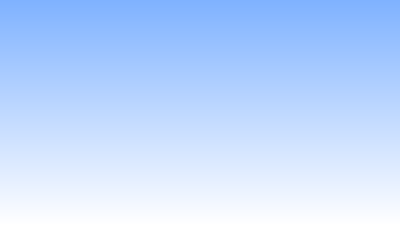

In [17]:
a: Float[t.Tensor, "h 1"] = t.linspace(0, 1, image_height).unsqueeze(1)

# Interpolate
white: t.Tensor = t.tensor([1.0, 1.0, 1.0])
light_blue: t.Tensor = t.tensor([0.5, 0.7, 1.0])
background_colors: Float[t.Tensor, "h 3"] = a * light_blue + (1.0 - a) * white

# Expand the result to match the width dimension (broadcasting the values)
background_colors: Float[t.Tensor, "h w c"] = background_colors.unsqueeze(1).expand(-1, image_width, -1) * 255

tensor_to_image(background_colors)

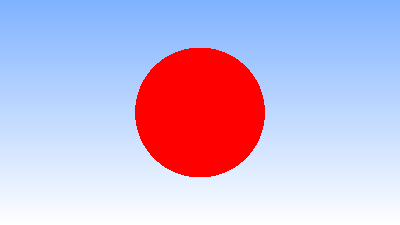

In [18]:
@jaxtyped(typechecker=typechecker)
def render_sphere_hit(pixel_rays: Float[t.Tensor, "h w 3 2"], sphere_center: Float[t.Tensor, "3"], sphere_radius: float) -> t.Tensor:
    # Calculate rays that instersect with sphere
    # r(t) = t(O-Pixel) ; P := (C-P)'*(C-P)=radius^2

    origin: Float[t.Tensor, "3"] = pixel_rays[:, :, :, 0][0][0]
    pixel_directions: Float[t.Tensor, "h w 3"] = pixel_rays[:, :, :, 1]
    oc: Float[t.Tensor, "3"] = origin - sphere_center

    # Discriminiant of second order equation
    a: Float[t.Tensor, "h w"] = t.ones_like(
        pixel_directions[:, :, 0]
    )  # t.norm(pixel_rays, dim=2).pow(2) = 1 since they are normalized
    b: Float[t.Tensor, "h w"] = 2.0 * t.einsum("h w c, c -> h w", pixel_directions, oc)
    c: Float[t.Tensor, "h w"] = ein.repeat(
        oc.dot(oc) - t.Tensor([sphere_radius**2]), "1 -> h w", w=image_width, h=image_height
    )
    discriminant: Float[t.Tensor, "h w"] = b * b - 4 * c * a
    sphere_hit: Bool[t.Tensor, "h w"] = discriminant >= 0
    return sphere_hit


sphere_center: t.Tensor = t.tensor([0.0, 0.0, -1.0])
sphere_radius: float = 0.5
sphere_hit = render_sphere_hit(pixel_rays, sphere_center, sphere_radius)
img = background_colors.clone()
img[sphere_hit] = t.tensor([255.0, 0.0, 0.0])  # Red color for the sphere
tensor_to_image(img)

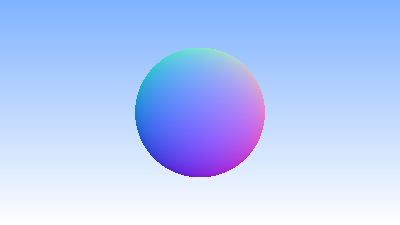

In [19]:
@jaxtyped(typechecker=typechecker)
def render_sphere(pixel_rays: Float[t.Tensor, "h w 3 2"], sphere_center: Float[t.Tensor, "3"], sphere_radius: float) -> Tuple[t.Tensor, t.Tensor]:

    # Calculate where do the rays insterect the sphere surface
    # r(t) = t(O-Pixel) ; P := (C-P)'*(C-P)=radius^2
    origin: Float[t.Tensor, "3"] = pixel_rays[:, :, :, 0][0][0]
    pixel_directions: Float[t.Tensor, "h w 3"] = pixel_rays[:, :, :, 1]
    oc: Float[t.Tensor, "3"] = origin - sphere_center

    # Discriminiant of second order equation
    a: Float[t.Tensor, "h w"] = t.ones_like(pixel_directions[:, :, 0]) #t.norm(pixel_directions, dim=2).pow(2) = 1 since they are normalized
    b: Float[t.Tensor, "h w"] = 2.0 * t.einsum("h w c, c -> h w", pixel_directions, oc)
    c_scalar: float = oc.dot(oc) - sphere_radius ** 2
    c: Float[t.Tensor, "h w"] = c_scalar.expand(image_height, image_width)
    discriminant: Float[t.Tensor, "h w"] = b * b - 4 * c * a
    sphere_hit: Bool[t.Tensor, "h w"] = discriminant >= 0

    # Roots of hit equation
    t0 = t.zeros_like(discriminant)
    t1 = t.zeros_like(discriminant)

    sqrt_discriminant = t.zeros_like(discriminant)
    sqrt_discriminant[sphere_hit] = t.sqrt(discriminant[sphere_hit])

    t0[sphere_hit] = (-b[sphere_hit] - sqrt_discriminant[sphere_hit]) / (2.0 * a[sphere_hit])
    t1[sphere_hit] = (-b[sphere_hit] + sqrt_discriminant[sphere_hit]) / (2.0 * a[sphere_hit])

    # Choose smallest positive t
    t_min = t.where((t0 > 0) & (t0 < t1), t0, t1)
    valid_t = (t_min > 0)
    sphere_hit = sphere_hit & valid_t

    # Assign the smallest positive t to origin_to_sphere where sphere_hit is True
    origin_to_sphere: Float[t.Tensor, "h w"] = t.full_like(discriminant, -1.0, dtype=t.float32)
    origin_to_sphere[sphere_hit] = t_min[sphere_hit]
    # Compute hit points and normals where sphere_hit is True
    hit_points = origin + pixel_directions * origin_to_sphere.unsqueeze(2)

    normal_vectors = F.normalize(hit_points - sphere_center, dim=2)
    return sphere_hit, normal_vectors


sphere_center: t.Tensor = t.tensor([0.0, 0.0, -1.0])
sphere_radius: float = 0.5
sphere_hit, normal_vectors = render_sphere(pixel_rays, sphere_center, sphere_radius)
img = background_colors.clone()
img[sphere_hit] = ((normal_vectors[sphere_hit] + 1) * 0.5 * 255).to(dtype=img.dtype)  # maps values in -1, 1 to 0, 255
tensor_to_image(img)

In [20]:
class HitRecord:
    """Class to register ray-object intersections."""

    def __init__(
        self,
        hit: Bool[t.Tensor, "h w"],
        point: Float[t.Tensor, "h w 3"],
        normal: Float[t.Tensor, "h w 3"],
        t: Float[t.Tensor, "h w"],
        front_face: Bool[t.Tensor, "h w"] = None,
    ):
        self.hit = hit
        self.point = point
        self.normal = normal
        self.t = t
        self.front_face = front_face

    def set_face_normal(
        self, ray_direction: Float[t.Tensor, "h w 3"], outward_normal: Float[t.Tensor, "h w 3"]
    ) -> None:
        """Determines whether the hit is from the outside or inside."""
        self.front_face = (ray_direction * outward_normal).sum(dim=2) < 0
        self.normal = t.where(self.front_face.unsqueeze(-1), outward_normal, -outward_normal)

    @staticmethod
    def empty(h: int, w: int, device: t.device = "cpu") -> "HitRecord":
        """Creates an empty HitRecord with default values."""
        hit = t.full((h, w), False, dtype=t.bool, device=device)
        point = t.zeros((h, w, 3), dtype=t.float32, device=device)
        normal = t.zeros((h, w, 3), dtype=t.float32, device=device)
        t_values = t.full((h, w), float("inf"), dtype=t.float32, device=device)
        front_face = t.full((h, w), False, dtype=t.bool, device=device)
        return HitRecord(hit, point, normal, t_values, front_face)


class Hittable(ABC):
    """Abstract class for hittable objects."""

    @abstractmethod
    def hit(self, pixel_rays: Float[t.Tensor, "h w 3 2"], t_min: float, t_max: float) -> HitRecord:
        pass


# Define the Sphere class
class Sphere(Hittable):
    def __init__(self, center: Float[t.Tensor, "3"], radius: float):
        self.center: Float[t.Tensor, "3"] = center
        self.radius: float = max(radius, 0.0)
        self.hit_record: None | HitRecord = None

    def hit(self, pixel_rays: Float[t.Tensor, "h w 3 2"], t_min: float, t_max: float) -> HitRecord:
        h, w = pixel_rays.shape[:2]
        record = HitRecord.empty(h, w, device=pixel_rays.device)
        # Vector from ray origin to sphere center
        origin: Float[t.Tensor, "3"] = pixel_rays[:, :, :, 0][0][0]
        pixel_directions: Float[t.Tensor, "h w 3"] = pixel_rays[:, :, :, 1]
        oc: Float[t.Tensor, "3"] = origin - self.center

        # Quadratic coefficients
        a: float = 1.0  # Since pixel_rays is normalized
        b: Float[t.Tensor, "h w"] = 2.0 * t.einsum("h w c, c -> h w", pixel_directions, oc)
        c_scalar: float = oc.dot(oc) - self.radius**2
        discriminant: Float[t.Tensor, "h w"] = b.pow(2) - 4 * c_scalar

        # Initialize masks and t_hit
        sphere_hit: Bool[t.Tensor, "h w"] = discriminant >= 0
        t_hit: Float[t.Tensor, "h w"] = t.full_like(discriminant, float("inf"))

        # Compute square roots where discriminant is non-negative
        sqrt_discriminant: Float[t.Tensor, "h w"] = t.zeros_like(discriminant)
        sqrt_discriminant[sphere_hit] = t.sqrt(discriminant[sphere_hit])

        # Compute both roots
        t0: Float[t.Tensor, "h w"] = t.zeros_like(discriminant)
        t1: Float[t.Tensor, "h w"] = t.zeros_like(discriminant)
        t0[sphere_hit] = (-b[sphere_hit] - sqrt_discriminant[sphere_hit]) / (2.0 * a)
        t1[sphere_hit] = (-b[sphere_hit] + sqrt_discriminant[sphere_hit]) / (2.0 * a)

        # Masks for valid t0 and t1
        t0_valid: Bool[t.Tensor, "h w"] = (t0 > t_min) & (t0 < t_max)
        t1_valid: Bool[t.Tensor, "h w"] = (t1 > t_min) & (t1 < t_max)

        t_hit: Float[t.Tensor, "h w"] = t.where((t0_valid) & (t0 < t_hit), t0, t_hit)
        t_hit: Float[t.Tensor, "h w"] = t.where((t1_valid) & (t1 < t_hit), t1, t_hit)

        sphere_hit = sphere_hit & (t_hit < float("inf"))

        # Compute hit points and normals where sphere_hit is True
        hit_points: Float[t.Tensor, "h w 3"] = origin + pixel_directions * t_hit.unsqueeze(-1)
        normal_vectors: Float[t.Tensor, "h w 3"] = F.normalize(hit_points - self.center, dim=2)

        # Update the hit record
        record.hit = sphere_hit
        record.point = t.where(sphere_hit.unsqueeze(-1), hit_points, record.point)
        record.t = t.where(sphere_hit, t_hit, record.t)
        record.set_face_normal(pixel_directions, normal_vectors)
        self.hit_record = record

        return record

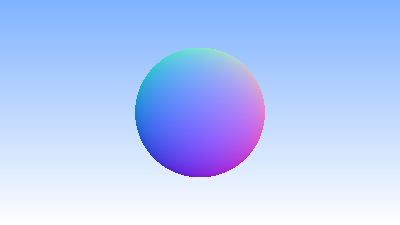

In [21]:
sphere_center: Float[t.Tensor, "3"] = t.tensor([0.0, 0.0, -1.0])
sphere_radius: float = 0.5

sphere: Sphere = Sphere(center=sphere_center, radius=sphere_radius)

t_min: float = 0.0
t_max: float = float('inf')

sphere.hit(pixel_rays, t_min, t_max)
img: Float[t.Tensor, "h w 3"] = background_colors.clone()
img[sphere.hit_record.hit] = ((sphere.hit_record.normal[sphere.hit_record.hit] + 1) * 0.5 * 255).to(dtype=img.dtype)

# Clamp values to [0, 255] and convert to uint8
img_uint8: Int[t.Tensor, "h w 3"] = img.clamp(0, 255).to(dtype=t.uint8)
image: Image.Image = tensor_to_image(img_uint8)
image

In [22]:
class HittableList(Hittable):
    def __init__(self, objects: List[Hittable]):
        self.objects: List[Hittable] = objects
        self.hit_record: None | HitRecord = None

    def hit(self, pixel_rays: Float[t.Tensor, "h w 3 2"], t_min: float, t_max: float) -> HitRecord:
        h, w = pixel_rays.shape[:2]
        record = HitRecord.empty(h, w, device=pixel_rays.device)
        closest_so_far: Float[t.Tensor, "h w"] = t.full_like(record.t, t_max)

        for obj in self.objects:
            # Call the hit function of the object
            obj.hit(pixel_rays, t_min, t_max)

            # Create a mask where the current object is closer than any previous hit
            closer_mask: Bool[t.Tensor, "h w"] = obj.hit_record.hit & (obj.hit_record.t < closest_so_far)
            closest_so_far = t.where(closer_mask, obj.hit_record.t, closest_so_far)

            # Update the main hit record where the current object is closer
            record.hit = record.hit | obj.hit_record.hit
            record.point = t.where(closer_mask.unsqueeze(-1), obj.hit_record.point, record.point)
            record.normal = t.where(closer_mask.unsqueeze(-1), obj.hit_record.normal, record.normal)
            record.t = t.where(closer_mask, obj.hit_record.t, record.t)

        record.set_face_normal(pixel_rays[:, :, :, 1], record.normal)
        self.hit_record = record
        return record


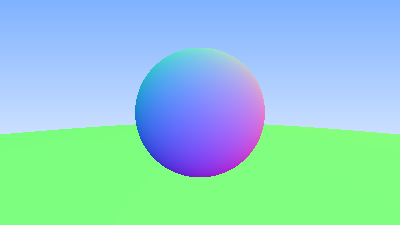

In [23]:
sphere_center = t.tensor([0.0, 0.0, -1.0]) 
sphere_radius = 0.5

sphere = Sphere(center=sphere_center, radius=sphere_radius)
ground = Sphere(center=t.tensor([0.0, -100.5, -1.0]), radius=100)  # Ground sphere below the main sphere
world = HittableList([sphere, ground])

t_min = 0.0
t_max = float('inf')

world.hit(pixel_rays, t_min, t_max)
img = background_colors.clone()
img[world.hit_record.hit] = ((world.hit_record.normal[world.hit_record.hit] + 1) * 0.5 * 255).to(dtype=img.dtype)

# Clamp values to [0, 255] and convert to uint8
img_uint8 = img.clamp(0, 255).to(dtype=t.uint8)
image = tensor_to_image(img_uint8)
image


In [24]:
class Camera:
    def __init__(
        self,
        origin: Float[t.Tensor, "3"] = t.Tensor([0.0, 0.0, 0.0]),
        focal_length: float = 1.0,
        aspect_ratio: float = 16.0 / 9.0,
        image_width: int = 400,
        viewport_height: float = 2.0,
        samples_per_pixel: int = 10,
    ):
        self.origin: Float[t.Tensor, "3"] = origin
        self.focal_length: float = focal_length
        self.samples_per_pixel: int = samples_per_pixel

        self.aspect_ratio: float = aspect_ratio
        self.image_width: int = image_width
        self.image_height: int = max(1, int(image_width / aspect_ratio))

        self.viewport_height: float = viewport_height
        self.viewport_width: float = viewport_height * (image_width / self.image_height)

        # x-axis
        left_border: float = -self.viewport_width / 2
        width_pixel_delta: float = self.viewport_width / image_width
        pixels_x: Float[t.Tensor, "w"] = t.linspace(
            left_border + width_pixel_delta / 2, -left_border - width_pixel_delta / 2, image_width
        )

        # y-axis
        top_border: float = viewport_height / 2
        height_pixel_delta: float = viewport_height / self.image_height
        pixels_y: Float[t.Tensor, "h"] = t.linspace(
            -top_border + height_pixel_delta / 2, top_border - height_pixel_delta / 2, self.image_height
        )

        # z-axis
        pixels_z: Float[t.Tensor, "1"] = t.Tensor([-focal_length])

        # Generate coordinate grids
        grid_x, grid_y, grid_z = t.meshgrid(pixels_x, pixels_y, pixels_z, indexing="ij")
        viewport_pixels = t.stack([grid_x, grid_y, grid_z], dim=-1)
        self.viewport_pixels = viewport_pixels.permute(1, 0, 2, 3).reshape(self.image_height, image_width, 3)
        self.pixel_rays: Float[t.Tensor, "h w 3 2"] = t.stack(
            [origin.expand(self.image_height, image_width, 3), self.viewport_pixels - origin], dim=-1
        )
        self.pixel_rays = F.normalize(self.pixel_rays, dim=2)

    def ray_color(
        self, background_colors: Float[t.Tensor, "h w 3"], hit_record: HitRecord
    ) -> Float[t.Tensor, "h w 3"]:

        background_colors[hit_record.hit] = ((hit_record.normal[hit_record.hit] + 1) * 0.5 * 255).to(
            dtype=background_colors.dtype
        )

        return background_colors

    def render(self, world: Hittable) -> Float[t.Tensor, "h w 3"]:

        # Background color gradient
        white: t.Tensor = t.tensor([1.0, 1.0, 1.0])
        light_blue: t.Tensor = t.tensor([0.5, 0.7, 1.0])
        a: Float[t.Tensor, "h 1"] = t.linspace(0, 1, self.image_height).unsqueeze(1)
        background_colors: Float[t.Tensor, "h 3"] = a * light_blue + (1.0 - a) * white
        background_colors: Float[t.Tensor, "h w c"] = (
            background_colors.unsqueeze(1).expand(-1, self.image_width, -1) * 255
        )

        # Antialiasing
        for i in range(self.samples_per_pixel):
            hit_record: HitRecord = world.hit(self.pixel_rays, 0.0, float("inf"))

            # Ray color
            img = self.ray_color(background_colors, hit_record)
            array = img.cpu().numpy().astype(np.uint8)
            array = array[::-1, :, :]

        
        return Image.fromarray(array, mode="RGB")

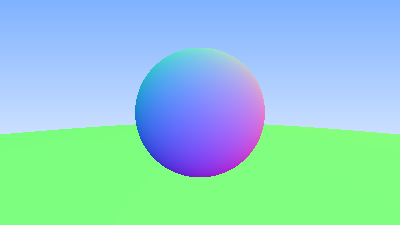

In [25]:
sphere_center = t.tensor([0.0, 0.0, -1.0]) 
sphere_radius = 0.5

sphere = Sphere(center=sphere_center, radius=sphere_radius)
ground = Sphere(center=t.tensor([0.0, -100.5, -1.0]), radius=100)
world = HittableList([sphere, ground])

camera = Camera(image_width=400)
img = camera.render(world)
display(img)